In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re



In [2]:
# Load the training dataset
df_train = pd.read_csv('ta-emotion10-trainset.csv')
df_train[['Emotion', 'Message']] = df_train['Neutral\tநாளைக்கு அரிசிக்கு இந்த நிலமை வந்தா 🙂'].str.split('\t', expand=True)
df_train.drop('Neutral\tநாளைக்கு அரிசிக்கு இந்த நிலமை வந்தா 🙂', axis=1, inplace=True)

# Prepare features and labels
X_train = df_train['Message']
y_train = df_train['Emotion']

# Load the test dataset
df_test = pd.read_csv('ta-emotion10_test.csv')
df_test[['Emotion', 'Message']] = df_test['Joy\tஅருமை அற்புதம் பிரமாதம் நண்பரே வாழ்த்துக்கள் நண்பரே வாழ்க வளமுடன் நலமுடன் தொடரட்டும் தங்களது பணி மதுரை சிவசங்கரன் ஆர்டிஸ்ட் திருவல்லிக்கேணி சென்னை'].str.split('\t', expand=True)
df_test.drop('Joy\tஅருமை அற்புதம் பிரமாதம் நண்பரே வாழ்த்துக்கள் நண்பரே வாழ்க வளமுடன் நலமுடன் தொடரட்டும் தங்களது பணி மதுரை சிவசங்கரன் ஆர்டிஸ்ட் திருவல்லிக்கேணி சென்னை', axis=1, inplace=True)

X_test = df_test['Message']
y_test = df_test['Emotion']



In [3]:
# Tokenization and padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

num_classes = len(le.classes_)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)


C:\Users\mayan\AppData\Local\Temp\ipykernel_2712\18216722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


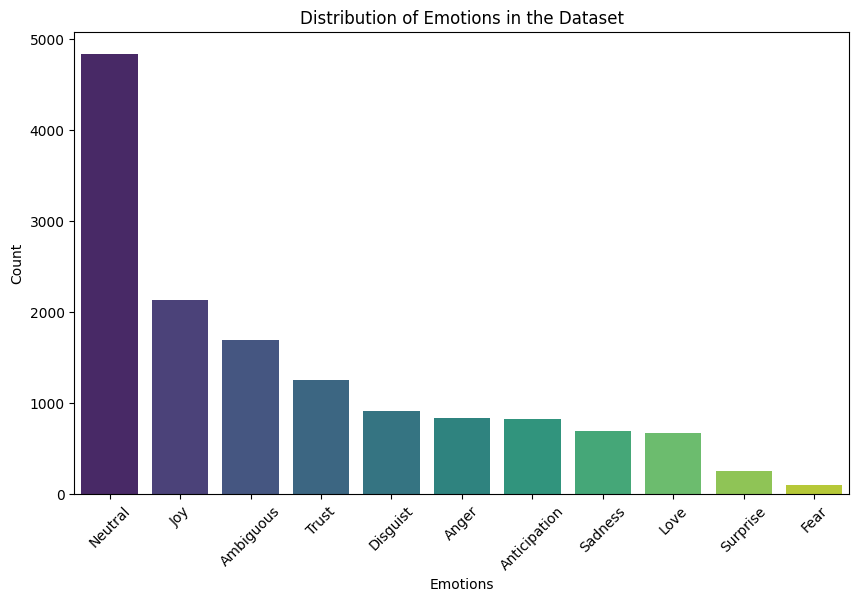

In [12]:
# Count occurrences of each emotion
emotion_counts = df_train['Emotion'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

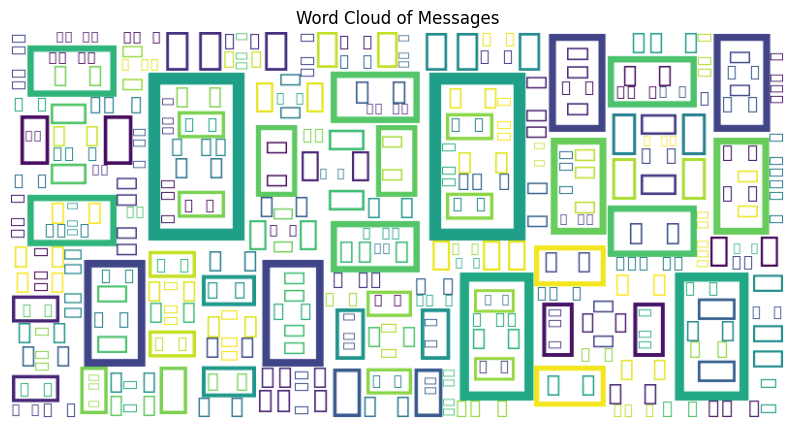

In [16]:
from wordcloud import WordCloud

# Combine all messages into one string
all_messages = ' '.join(df_train['Message'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_messages)

# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Messages')
plt.show()

In [7]:
# Build the enhanced LSTM model
model_enhanced = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_enhanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [9]:
# Train the model
history = model_enhanced.fit(X_train_padded, y_train_categorical, 
                              batch_size=32, epochs=15, 
                              validation_split=0.2, 
                              callbacks=[early_stopping],
                              verbose=1)

# Evaluate the model
test_loss, test_acc = model_enhanced.evaluate(X_test_padded, y_test_categorical)
print(f'\nTest Accuracy: {test_acc:.4f}')

Epoch 1/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.3511 - loss: 2.0105 - val_accuracy: 0.3797 - val_loss: 1.8917
Epoch 2/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.4196 - loss: 1.7118 - val_accuracy: 0.3624 - val_loss: 1.8804
Epoch 3/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.5533 - loss: 1.3393 - val_accuracy: 0.3001 - val_loss: 2.0328
Epoch 4/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.6731 - loss: 1.0220 - val_accuracy: 0.3248 - val_loss: 2.3248
Epoch 5/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 47s 131ms/step - accuracy: 0.7447 - loss: 0.7818 - val_accuracy: 0.3251 - val_loss: 2.6323
Epoch 6/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.8019 - loss: 0.6301 - val_accuracy: 0.3030 - val_loss: 2.9898
Epoch 7/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.8394 - loss: 0.5131 - val_accuracy: 0.3297 - val_loss: 3.2250
Epoch 8/15
356/356 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.8679 - loss: 0.4

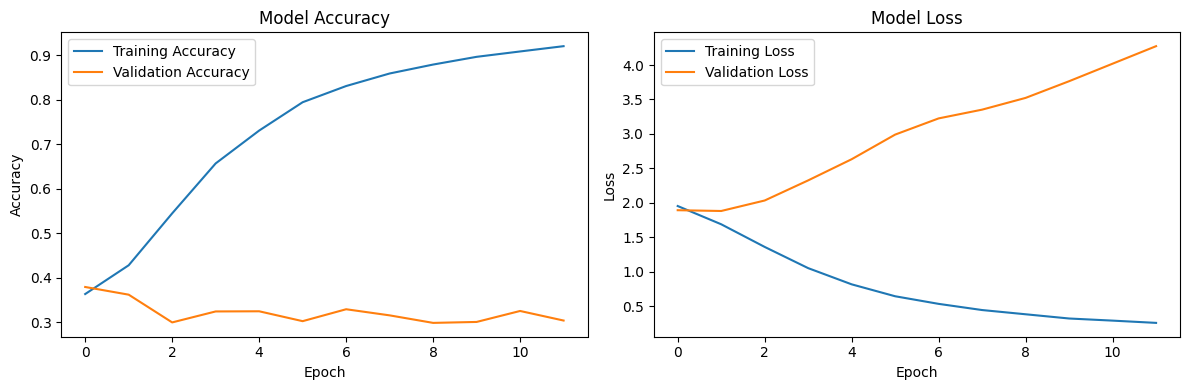

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()